# Solution for delta source

A script that numerically evaluates the convolution with a delta source.

In [1]:
# include necessary libraries
import numpy as np
import sympy as sp
from sympy.utilities import lambdify
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.special import binom

In [13]:
# We will create a class for the pressure estimator
# It is going to be a list of functions with vectorized inputs that is then calculated
class estimator:
    # Constructor
    def __init__(self,max_order:int=0):
        self.max_order  = max_order     # Maximum order to calculate for
        self.terms_slow = []            # A list for the terms to be calculated for v<1
        self.terms_fast = []            # A list for the terms to be calculated for v>1

        # Now calculate the terms
        print('Generating Estimator for order %d'%self.max_order)
        self.assemble_slow()
        self.assemble_fast()

    # Coefficient
    def C(self, n:int, m:int, l:int):
        return (-2)**m * (-1)**l * np.math.factorial(l) * binom(2*n - m, n) * binom(m,l)**2/ (4**(n+1) * np.pi * np.math.factorial(m))
    
    # Get the slow terms
    def get_slow_term(self,n:int,m:int,l:int):
        # some symbols
        v       = sp.Symbol('v')
        g_sq    = 1/(1-v**2)
        rho     = sp.Symbol('r')
        t       = sp.Symbol('t')
        Z       = sp.Symbol('Z')
        z       = sp.Symbol('z')
        a       = sp.Symbol('a')
        s       = sp.Symbol('s')
        q       = 1/(1+sp.exp(-a*(t-(rho**2 + Z**2)**(1/2)-s)))

        # Calculate the derivatives
        der = v**(m-l)*sp.diff(q*(rho**2 + Z**2)**((m-l)/2)/((rho**2 + Z**2)**(1/2)-v*Z),Z,m-l)

        # Calculate the solution for slow speed
        Z_slow = g_sq * (z - v* t) + v * ((g_sq * (z - v* t))**2 + g_sq * rho**2)**(1/2)

        # Now plug in the solution for slow speed
        der = der.subs(Z,Z_slow)

        # Calculate the time derivative
        der = sp.diff(der,t,n)

        # Return the derivative
        return der
        
    # Get the fast terms
    def get_fast_term(self,n:int,m:int,l:int):
        # some symbols
        v       = sp.Symbol('v')
        g_sq    = 1/(1-v**2)
        rho     = sp.Symbol('r')
        t       = sp.Symbol('t')
        Z       = sp.Symbol('Z')
        z       = sp.Symbol('z')
        a       = sp.Symbol('a')
        s       = sp.Symbol('s')
        q       = 1/(1+sp.exp(-a*(t-(rho**2 + Z**2)**(1/2)-s)))

        # Calculate the derivatives
        der = v**(m-l)*sp.diff(q*(rho**2 + Z**2)**((m-l)/2)/((rho**2 + Z**2)**(1/2)-v*Z),Z,m-l)

        # Calculate the solution for +-
        Z_p = g_sq * (z - v* t) + v * ((g_sq * (z - v* t))**2 + g_sq * rho**2)**(1/2)
        Z_m = g_sq * (z - v* t) - v * ((g_sq * (z - v* t))**2 + g_sq * rho**2)**(1/2)

        # Now plug in the solution for slow speed
        der = der.subs(Z,Z_p) + der.subs(Z,Z_m)

        # Calculate the time derivative
        der = sp.diff(der,t,n)

        # Return the derivative
        return der

    # Assembles the terms for the slow particles
    def assemble_slow(self):
        # Define some symbols
        v       = sp.Symbol('v')
        L       = sp.Symbol('L')
        r       = sp.Symbol('r')
        t       = sp.Symbol('t')
        z       = sp.Symbol('z')
        a       = sp.Symbol('a')
        s       = sp.Symbol('s')

        # Add the terms
        for n in tqdm(range(self.max_order+1),desc='Assembling Estimator for v<1'):
            for m in tqdm(range(n+1),leave=False):
                for l in tqdm(range(m+1),leave=False):
                    f = lambdify([r,z,t,v,L,a,s],L**n * self.C(n,m,l) * self.get_slow_term(n,m,l),'numpy')
                    self.terms_slow.append(f)
        
    # Assembles the terms for the slow particles
    def assemble_fast(self):
        # Define some symbols
        v       = sp.Symbol('v')
        L       = sp.Symbol('L')
        r       = sp.Symbol('r')
        t       = sp.Symbol('t')
        z       = sp.Symbol('z')
        a       = sp.Symbol('a')
        s       = sp.Symbol('s')

        # Add the terms
        i = 0
        for n in tqdm(range(self.max_order+1),desc='Assembling Estimator for v>1'):
            for m in tqdm(range(n+1),leave=False):
                for l in tqdm(range(m+1),leave=False):
                    f = lambdify([r,z,t,v,L,a,s], L**n * self.C(n,m,l) * self.get_fast_term(n,m,l),'numpy')

                    g = (lambda F: lambda rr,zz,tt,vv,ll,aa,ss: 0 if abs(zz-vv*tt) <= rr*(vv**2 - 1) or (zz-vv*tt) > 0. else F(rr,zz,tt,vv,ll,aa,ss))(f)
                    g = np.vectorize(g,excluded=['vv','ll','aa','ss'])
                    self.terms_fast.append(g)
                    i+=1
    
    # Actually make a prediction given a set of data
    def __call__(self,r,z,t,v,l,a,s):
        if v == 1: v = 0.9999999
        if v < 1:
            sum = 0
            for f in self.terms_slow: sum += f(r,z,t,v,l,a,s)
            return sum
        else:
            sum = 0
            for g in self.terms_fast: sum += g(r,z,t,v,l,a,s)
            return sum

        

In [36]:
# Now that we have our functions defined, let's plot some stuff
E = estimator(max_order=3)

Generating Estimator for order 3


Assembling Estimator for v<1:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

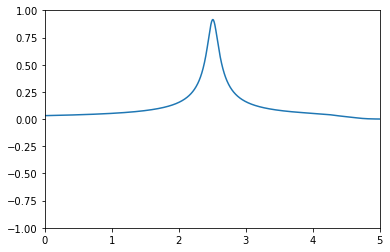

In [35]:
# Plotting parameters
N_pts   = 1000
z_lims  = (0,5)
z       = np.linspace(*z_lims,N_pts)
t       = 5
r       = 0.1
v       = 0.5
lamda   = 0.02
a       = 5
s       = 1


plt.ylim(-1,1)
plt.xlim(*z_lims)
plt.plot(z,E(r,z,t,v,lamda,a,s));